## 3.1 시맨틱 분할이란

#### 3.1.1 시맨틱 분할 개요
* 시맨틱 분할
    * 한 장의 이미지에 포함된 여러 영역과 이름을 픽섹 수준에서 지정하는 작업
    * BBox가 아닌 픽셀 수준으로 어떠한 클래스 물체인지 라벨을 붙임

#### 3.1.2 시멘틱 분할 입출력
* 시맨틱 분할의 입력
    * 이미지
* 시맨틱 분할의 출력
    * 각 픽셀이 속한 클래스의 라벨 정보
* 컬러 팔레트 형식
    * 이미지 표현 기법
    * 0부터 순서대로 각 숫자에 RGB를 대응시킨 컬러 팔레트를 준비하고 RGB 값 대응

#### 3.1.4 PSPNet을 활용한 물체 감지 흐름
1. 전처리
    * 이미지 resize(475X475)
        * PSPNet에서는 임의의 크기로 resize했지만, 책에서는 475픽셀
    * 색상 표준화
2. PSPNet 신경망에 전처리한 화상 입력
    * 출력: 21X475X475(클래스 수 높이, 폭)의 배열
    * 출력 배열 값: 각 픽셀이 해당 클래스일 신뢰도(확률)에 대응
3. PSPNet 출력 값에 픽셀별로 신뢰도가 가장 높은 클래스와 각 픽셀이 대응할 것으로 예상되는 클래스를 구함
    * 시맨틱 분할의 출력: 픽셀별 신뢰도가 가장 높은 클래스 정보
4. 시맨틱 분할의 출력을 원래 크기로 resize

## 3.2 데이터셋과 데이터로더 구현

#### 3.2.1 폴더 준비
* `pspnet50_ADE20K.pth`: PSPNet 초기값으로 사용

In [3]:
import os
import urllib.request
import zipfile
import tarfile

In [4]:
data_dir = "./data/"
if not os.path.exists(data_dir):
    os.mkdir(data_dir)

In [5]:
weights_dir = "./weights/"
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

In [6]:
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar"
target_path = os.path.join(data_dir, "VOCtrainval_11-May-2012.tar") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)
    
    tar = tarfile.TarFile(target_path)
    tar.extractall(data_dir)  
    tar.close()

#### 3.2.2 화상 데이터 및 어노테이션 데이터 파일의 경로 리스트 작성
* 시맨틱 분할 대상 파일의 정보
    * `data/VOCdevkit/VOC2012/ImageSets/Segmentation/`
    * `train.txt`, `val.txt`파일에 적혀있음
* 어노테이션 데이터
    * `data/VOCdevkit/VOC2012/SegmentationClass`에 저장된 `PNG`이미지 파일

In [7]:
# 패키지 import
import torch
import random
import os.path as osp
import numpy as np
from PIL import Image
import torch.utils.data as data

In [8]:
# 난수시드 설정
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [9]:
def make_datapath_list(rootpath):
    """
    학습 및 검증용 이미지 데이터와 어노테이션 데이터의 파일 경로 리스트 작성

    Parameters
    ----------
    rootpath : str
        데이터 폴더 경로

    Returns
    -------
    ret : train_img_list, train_anno_list, val_img_list, val_anno_list
        데이터 경로를 저장한 리스트
    """

    # 이미지 파일과 어노테이션 파일의 경로 템플릿 작성
    imgpath_template = osp.join(rootpath, 'JPEGImages', '%s.jpg')
    annopath_template = osp.join(rootpath, 'SegmentationClass', '%s.png')

    # 훈련 및 검증 파일 각각 ID(파일 이름) 취득
    train_id_names = osp.join(rootpath + 'ImageSets/Segmentation/train.txt')
    val_id_names = osp.join(rootpath + 'ImageSets/Segmentation/val.txt')

    # 훈련 데이터의 이미지 파일과 어노테이션 파일의 경로 리스트 작성
    train_img_list = list()
    train_anno_list = list()

    for line in open(train_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        train_img_list.append(img_path)
        train_anno_list.append(anno_path)

    # 검증 데이터의 이미지 파일과 어노테이션 파일의 경로 리스트 작성
    val_img_list = list()
    val_anno_list = list()

    for line in open(val_id_names):
        file_id = line.strip()  # 공백과 줄 바꿈 제거
        img_path = (imgpath_template % file_id)  # 이미지 경로
        anno_path = (annopath_template % file_id)  # 어노테이션 경로
        val_img_list.append(img_path)
        val_anno_list.append(anno_path)

    return train_img_list, train_anno_list, val_img_list, val_anno_list


In [10]:
# 동작 확인: 파일 경로 리스트 취득
rootpath = "./data/VOCdevkit/VOC2012/"

train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

print(train_img_list[0])
print(train_anno_list[0])

./data/VOCdevkit/VOC2012/JPEGImages\2007_000032.jpg
./data/VOCdevkit/VOC2012/SegmentationClass\2007_000032.png


#### 3.2.3 데이터셋 작성
* `DataTransform` 클래스
    * `Dataset`클래스를 작성하기 전, 이미지와 어노테이션을 전처리하는 클래스
    * `utils/data_augumentation.py` 사용
    
    * 화상 데이터와 어노테이션 데이터를 세트로 변환
        * `Compose`클래스 내에서 변환
    * 훈련 데이터 확장
        * `Scale`
        * `resize`
        * `RandomRotation`
            * -10도~10도 범위에서 화상 회전
        * `RandomMirror`
            * 1/2 확률로 좌우 반전
        * `Normalize_Tensor`
            * 화상 데이터를 파이토치 텐서 형식으로 변환 & 색상정보 표준화
    * 검증 데이터
        * 데이터 확장 실시 X
        * 변환 및 색상 정보 표준화만 적용

In [11]:
# 데이터 처리 클래스와 데이터 확장 클래스 import
from utils.data_augumentation import Compose, Scale, RandomRotation, RandomMirror, Resize, Normalize_Tensor


class DataTransform():
    """
    이미지와 어노테이션 전처리 클래스. 훈련 시와 검증 시 다르게 동작한다.
    이미지 크기를 input_size X input_size로 한다.
    훈련 시 데이터 확장을 수행한다.

    Attributes
    ----------
    input_size : int
        리사이즈 대상의 이미지 크기
    color_mean : (R, G, B)
        각 색상 채널의 평균값
    color_std : (R, G, B)
        각 색상 채널의 표준편자
    """

    def __init__(self, input_size, color_mean, color_std):
        self.data_transform = {
            'train': Compose([
                Scale(scale=[0.5, 1.5]),  # 이미지 확대
                RandomRotation(angle=[-10, 10]),  # 회전
                RandomMirror(),  # 랜덤미러
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색상 정보의 표준화와 텐서화
            ]),
            'val': Compose([
                Resize(input_size),  # 리사이즈(input_size)
                Normalize_Tensor(color_mean, color_std)  # 색상 정보의 표준화와 텐서화
            ])
        }

    def __call__(self, phase, img, anno_class_img):
        """
        Parameters
        ----------
        phase : 'train' or 'val'
            전처리 모드 지정
        """
        return self.data_transform[phase](img, anno_class_img)

* Dataset 클래스
    * `VOCDataset(train_img_list, train_anno_list, phase, transform)`

In [12]:
class VOCDataset(data.Dataset):
    """
    VOC2012의 Dataset을 만드는 클래스. 파이토치의 Dataset 클래스를 상속받는다.

    Attributes
    ----------
    img_list : 리스트
        이미지 경로를 저장한 리스트
    anno_list : 리스트 
        어노테이션 경로를 저장한 리스트
    phase : 'train' or 'test'
        학습 또는 훈련 설정
    transform : object
        전처리 클래스 인스턴스
    """

    def __init__(self, img_list, anno_list, phase, transform):
        self.img_list = img_list
        self.anno_list = anno_list
        self.phase = phase
        self.transform = transform

    def __len__(self):
        '''이미지의 매수 반환'''
        return len(self.img_list)

    def __getitem__(self, index):
        '''
        전처리한 이미지의 텐서 형식과 데이터 어노테이션 취득
        '''
        img, anno_class_img = self.pull_item(index)
        return img, anno_class_img

    def pull_item(self, index):
        '''이미지의 텐서 형식 데이터와 어노테이션 취득'''

        # 1. 이미지 읽기
        image_file_path = self.img_list[index]
        img = Image.open(image_file_path)   # [높이][폭][색RGB]

        # 2. 어노테이션 이미지 읽기
        anno_file_path = self.anno_list[index]
        anno_class_img = Image.open(anno_file_path)   # [높이][폭]

        # 3. 전처리 실시
        img, anno_class_img = self.transform(self.phase, img, anno_class_img)

        return img, anno_class_img

#### 데이터셋의 인스턴스가 만들어져 데이터를 꺼낼 수 있는지 확인

In [13]:
# 동작 확인
# (RGB) 색의 평균치와 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

# 데이터셋 작성
train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# 데이터 추출 예
print(val_dataset.__getitem__(0)[0].shape)
print(val_dataset.__getitem__(0)[1].shape)
print(val_dataset.__getitem__(0))

torch.Size([3, 475, 475])
torch.Size([475, 475])
(tensor([[[ 1.6667,  1.5125,  1.5639,  ...,  1.7523,  1.6667,  1.7009],
         [ 1.5810,  1.4269,  1.4783,  ...,  1.7009,  1.6153,  1.6495],
         [ 1.5639,  1.4098,  1.4440,  ...,  1.6838,  1.5982,  1.6324],
         ...,
         [-0.4739, -0.4911, -0.5424,  ...,  1.2557,  1.1872,  1.2214],
         [-0.5596, -0.4911, -0.4911,  ...,  1.2385,  1.1872,  1.2214],
         [-0.6281, -0.3883, -0.3369,  ...,  1.2385,  1.1872,  1.2214]],

        [[ 1.8333,  1.6758,  1.7283,  ...,  1.9209,  1.8333,  1.8683],
         [ 1.7458,  1.5882,  1.6408,  ...,  1.8683,  1.7808,  1.8158],
         [ 1.7283,  1.5707,  1.6057,  ...,  1.8508,  1.7633,  1.7983],
         ...,
         [-0.5826, -0.6001, -0.6527,  ...,  1.4132,  1.3431,  1.3431],
         [-0.6702, -0.6001, -0.6001,  ...,  1.3957,  1.3431,  1.3431],
         [-0.7402, -0.4951, -0.4426,  ...,  1.3957,  1.3431,  1.3431]],

        [[ 2.0474,  1.8905,  1.9428,  ...,  2.1346,  2.0474,  2.08

#### 3.2.4 데이터 로더 작성
* 어노테이션 데이터 크기가 데이터마다 변하는 것이 아니기 때문에 <br>파이토치의 `DataLoader` 클래스 사용 가능!
* 훈련 및 검증 데이터 각각 `DataLoader` 작성

In [14]:
# 데이터 로더 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전 오브젝트로 정리
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}

# 동작 확인
batch_iterator = iter(dataloaders_dict["val"])  # 반복자로 변환
imges, anno_class_imges = next(batch_iterator)  # 첫 번째 요소를 꺼낸다.
print(imges.size())  # torch.Size([8, 3, 475, 475])
print(anno_class_imges.size())  # torch.Size([8, 3, 475, 475])

torch.Size([8, 3, 475, 475])
torch.Size([8, 475, 475])


## 3.3 PSPNet 네트워크 구성 및 구현

#### 3.3.1 PSPNet
* PSPNet 네트워크
    * Feature(Encoder 모듈)
        * 목적: 입력 이미지의 특징 파악
        * 입력: 3⨉475⨉475
        * 출력: 2048⨉60⨉60(ch⨉높이⨉폭)
            * 화상 특징을 파악한 채널 2048개를 준비해야됨,,
    * Pyramid Polling
        * 픽셀의 물체 라벨을 구하기 위해서는 주변 정보 뿐만 아니라 더 넓은 범위의 화상 정보가 있어야 됨
        * 네 가지 특징량 맵
            * 이미지 전체를 차지하는 특징량
            * 이미지의 1/2를 차지하는 특징량
            * 이미지의 1/3을 차지하는 특징량
            * 이미지의 1/6을 차지하는 특징량
        * 출력: 4096⨉60⨉60
    * Decoder(업샘플링 모듈)
        * 목적
            1. Pyramid Pooling 모듈의 출력을 21⨉60⨉60 텐서로 변환
            2. 21⨉60⨉60 → 21⨉475⨉475(원래 이미지의 크기)
        * 추론시
            * Decoder 모듈의 출력으로 출력에 대한 최대 확률의 물체 클래스를 찾아 각 픽셀의 라벨을 결정
    * AuxLoss
        * Feature층 중간까지의 네트워크 파라미터 학습을 보조하는 역할(auxiliary)
        * 네트워크 결합 파라미터의 학습을 수월하게 하기 위해 AuxLoss모듈 사용
        * 손실함수 계산 보조
        * Feature모듈로 중간 텐서를 뻐내 입력 데이터로 받음
        * Feature 층 중간까지의 결과로 시맨틱 분할 실시
        * 입력: 1024⨉60⨉60
        * 출력: 21⨉475⨉475
    
   
   * 신경망 학습
       * AuxLoss모듈의 출력과 Decoder모듈의 출력을 모두 이미지의 어노테이션 데이터(정답정보)로 대응시켜 손실 값을 계산
       * 손실 값 계산 후, 손살 값에 따른 오차 역전파 법을 실시하여 네트워크의 결합 파라미터 갱신
       
   * 추론
        * Decoder 모듈의 출력만으로 시맨틱 분할 ~AuxLoss모듈 사용~
<img src = "../img/PSPNet module.PNG" alt ="PSPNet module image" width = "700px" height ="350px" align = "left">

#### 3.3.2 PSPPNet 클래스 구현
* PSPNet
    * 4개의 모듈이 있고 forward 메서드에서 순전파한다,,,
* `forward`
    * `PSPNet` 클래스의 메서드
    * 순서대로 각 모듈의 서브 네트워크 실행
    * 단, AuxLoss모듈을 Feature모듈의 featrue_dilated_res_1 뒤에 넣어 output_aux 변수로 출력을 작성
    * `return (output, output_aux)`

In [15]:
# 패키지 import
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class PSPNet(nn.Module):
    def __init__(self, n_classes):
        super(PSPNet, self).__init__()

        # 파라미터 설정
        block_config = [3, 4, 6, 3]  # resnet50
        img_size = 475
        img_size_8 = 60  # img_size의 1/8로 설정

        # 네 개의 모듈을 구성하는 서브 네트워크 준비
        self.feature_conv = FeatureMap_convolution()
        self.feature_res_1 = ResidualBlockPSP(
            n_blocks=block_config[0], in_channels=128, mid_channels=64, out_channels=256, stride=1, dilation=1)
        self.feature_res_2 = ResidualBlockPSP(
            n_blocks=block_config[1], in_channels=256, mid_channels=128, out_channels=512, stride=2, dilation=1)
        self.feature_dilated_res_1 = ResidualBlockPSP(
            n_blocks=block_config[2], in_channels=512, mid_channels=256, out_channels=1024, stride=1, dilation=2)
        self.feature_dilated_res_2 = ResidualBlockPSP(
            n_blocks=block_config[3], in_channels=1024, mid_channels=512, out_channels=2048, stride=1, dilation=4)

        self.pyramid_pooling = PyramidPooling(in_channels=2048, pool_sizes=[
            6, 3, 2, 1], height=img_size_8, width=img_size_8)

        self.decode_feature = DecodePSPFeature(
            height=img_size, width=img_size, n_classes=n_classes)

        self.aux = AuxiliaryPSPlayers(
            in_channels=1024, height=img_size, width=img_size, n_classes=n_classes)

    def forward(self, x):
        x = self.feature_conv(x)
        x = self.feature_res_1(x)
        x = self.feature_res_2(x)
        x = self.feature_dilated_res_1(x)

        output_aux = self.aux(x)  # Feature 모듈의 중간을 Aux 모듈로

        x = self.feature_dilated_res_2(x)

        x = self.pyramid_pooling(x)
        output = self.decode_feature(x)

        return (output, output_aux)


## 3.4 Feature 모듈 설명 및 구현(ResNet)
* Feature 모듈
    * 다섯 개의 서브 네트워크로 구성
        * FeatureMap_convolution
        * resodialBlockPSP
        * residualBlockPSP
        * residualBlockPSP(dilated)
            * 출력 텐서가 AuxLoss로,,,
            * AuxLoss 모듈에서 출력텐서로 픽셀별 클래스를 분류하고, <br>손실 값을 Feature모듈의 전반부 네 개의 서브 네트워크를 학습하는데 사용
        * residualBlockPSP(dilated)
* `FeatureMap_convolution`
* `ResidualBlockPSP`
* `dilation`

#### 3.4.2 서브 네트워크 FeatureMap_convolution
* FeatureMap_convolution모듈의 첫 번째 서브 네트워크
* 입력
    * 전처리된 이미지(3⨉475⨉475)
* 출력
    * 128⨉119⨉119
* 네 가지 요소로 구성
    * conv2dBatchNormRelu
        * 합성곱 층
        * 배치 정규화
        * Relu
    * 최대 풀링 층
* 단순히 합성곱, 배치 정규화, 최대 풀링으로 **이미지의 특징량을 추출**

#### 3.4.3 FeatureMap_convolution 구현
* `conv2dBatchNormRelu`
    * 합성곱 층, 배치 정규화, ReLU를 세트
    * 내부에서 사용하는 합성곱 층의 인수 지정
    * `Relu(inplace = True)`
        * 메모리 절약
* `FeatureMap_convolution`
    * `conv2dBatchNormRelu` 사용
    * `conv2dBatchNormrelu` 3개, 최대 풀링 층 1개
        * `forward`: 4개의 층을 순전파하는 메서드

In [17]:
class conv2DBatchNormRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNormRelu, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # inplase 설정으로 입력을 저장하지 않고 출력을 계산하여 메모리 절역

    def forward(self, x):
        x = self.conv(x)
        x = self.batchnorm(x)
        outputs = self.relu(x)

        return outputs


In [18]:
class FeatureMap_convolution(nn.Module):
    def __init__(self):
        '''구성할 네트워크 준비'''
        super(FeatureMap_convolution, self).__init__()

        # 합성곱 층 1
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 3, 64, 3, 2, 1, 1, False
        self.cbnr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 합성곱 층 2
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 64, 3, 1, 1, 1, False
        self.cbnr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 합성곱 층 3
        in_channels, out_channels, kernel_size, stride, padding, dilation, bias = 64, 128, 3, 1, 1, 1, False
        self.cbnr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size, stride, padding, dilation, bias)

        # 최대 풀링 층
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        x = self.cbnr_1(x)
        x = self.cbnr_2(x)
        x = self.cbnr_3(x)
        outputs = self.maxpool(x)
        return outputs


#### 3.4.4 ResidualBlockPSP
* ResidualNetwork(ResNet) 신경망에서 사용되는 ResidualBlock구조 사용
* `bottleNeckPSP`클래스를 지나 `bottleNeckIdentifyPSP`클래스를 여러 번 반복하여 출력
    * 4개의 `ResidualBlockPSP`서브 네트워크를 지날 때, `bottleNeckIdentifyPSP` 클래스의 반복 횟수: 3, 4, 6, 3

#### RedisualBLockPSP 구현
* 생성자
    * `bottelNeckPSP`(1)
    * `bottleNeckIdentifyPSP`(여러개)
* `nn.Sequential`
    * 생성자에서 준비한 네트워크 클래스의 순전파를 자동실행하는 함수(forward)가 자동실행
    * forward함수를 정의하지 않아도 됨
        * `ReatureMap_convolution`구현에서는 `nn.Module`을 상속했기 때문에 forward함수가 필요함!

#### 3.4.5 bottleNeckPSP와 bottleNeckIdentifyPSP
* 입력이 두 갈래로 나뉘어 처리
    * 스킵 결합(bypass): 두 갈래로 나누어진 입력 아래쪽 루트
    * `ResidualBlock`
        * 스킵결합을 사용하는 서브 네트워크
        * 스킵결합으로 서브 네트워크 입력을 거의 그대로 결합 ,,
* `bottleNeckPSP`와 `bottleNeckIdentifyPSP`의 차이점
    * 스킵결합에서 합성곱 층의 유무
    * `bottleNeckPSP`: 스킵결합에 합성곱 층 한 번 적용
    * `bottleNeckIdentify`: 합성곱 층 적용 X
* `bottleNeckPSP`
* `bottleNeckIdentifyPSP`

In [19]:
class ResidualBlockPSP(nn.Sequential):
    def __init__(self, n_blocks, in_channels, mid_channels, out_channels, stride, dilation):
        super(ResidualBlockPSP, self).__init__()

        # bottleNeckPSP 준비
        self.add_module(
            "block1",
            bottleNeckPSP(in_channels, mid_channels,
                          out_channels, stride, dilation)
        )

        # bottleNeckIdentifyPSP 반복 준비
        for i in range(n_blocks - 1):
            self.add_module(
                "block" + str(i+2),
                bottleNeckIdentifyPSP(
                    out_channels, mid_channels, stride, dilation)
            )


In [20]:
class conv2DBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, dilation, bias):
        super(conv2DBatchNorm, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,
                              kernel_size, stride, padding, dilation, bias=bias)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.conv(x)
        outputs = self.batchnorm(x)

        return outputs


In [21]:
class bottleNeckPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, stride, dilation):
        super(bottleNeckPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=stride, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        # 스킵 결합
        self.cb_residual = conv2DBatchNorm(
            in_channels, out_channels, kernel_size=1, stride=stride, padding=0, dilation=1, bias=False)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = self.cb_residual(x)
        return self.relu(conv + residual)


In [23]:
class bottleNeckIdentifyPSP(nn.Module):
    def __init__(self, in_channels, mid_channels, stride, dilation):
        super(bottleNeckIdentifyPSP, self).__init__()

        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, mid_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.cbr_2 = conv2DBatchNormRelu(
            mid_channels, mid_channels, kernel_size=3, stride=1, padding=dilation, dilation=dilation, bias=False)
        self.cb_3 = conv2DBatchNorm(
            mid_channels, in_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        conv = self.cb_3(self.cbr_2(self.cbr_1(x)))
        residual = x
        return self.relu(conv + residual)

## 3.5 Pyramid Pooling 모듈 설명 및 구현
* `PyramidPooling` 클래스로 이루어진 하나의 서브 네트워크로 구성
* 입력
    * Feature모듈의 출력
    * 2048⨉60⨉60
* 출력
    * 4096⨉60⨉60
    * Pyramid Pooling으로 멀티 스케일 정보를 가짐
        * 해당 픽셀 주변에 있는 다양한 스케일 특징량 정보를 사용할 수 있음
        * 높은 정밀도의 시맨틱 분할 실현 가능!
    * 출력텐서 → DECODER 모듈

#### 3.5.2 PyramidPooling 클래스 구현

* PyramidPooling 클래스의 네트워크 구성
    * 입력을 다섯 개로 분기
    * `Adaptive Average Pooling`, `conv2DBatchNormRelu`, `UpSample`층 통과
        * `Adaptive Average Pooling` 층
            * `nn.AdaptiveAvgPool2d` 클래스 사용
        * `UpSample` 층
            * `F.interpolate` 연산으로 구현
    * 마지막에 하나의 텐서로 재결합
        * `torch.cat(output, dim = 1)`
             * 차원을 1을 기준으로 output 변수에 연결한다,,,
             * 차원 0: 미니 배치 수
             * 차원 1: 채널 수
             * 차원 2, 3: 높이, 폭

In [24]:
class PyramidPooling(nn.Module):
    def __init__(self, in_channels, pool_sizes, height, width):
        super(PyramidPooling, self).__init__()

        # forward에서 사용하는 이미지 크기
        self.height = height
        self.width = width

        # 각 합성곱 층의 출력 채널 수
        out_channels = int(in_channels / len(pool_sizes))

        # 각 합성곱 층 작성
        # 다음은 for문으로 구현하는 것이 좋지만 이해를 돕기 위해 상세하게 작성한다.
        # pool_sizes: [6, 3, 2, 1]
        self.avpool_1 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[0])
        self.cbr_1 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_2 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[1])
        self.cbr_2 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_3 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[2])
        self.cbr_3 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

        self.avpool_4 = nn.AdaptiveAvgPool2d(output_size=pool_sizes[3])
        self.cbr_4 = conv2DBatchNormRelu(
            in_channels, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False)

    def forward(self, x):

        out1 = self.cbr_1(self.avpool_1(x))
        out1 = F.interpolate(out1, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out2 = self.cbr_2(self.avpool_2(x))
        out2 = F.interpolate(out2, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out3 = self.cbr_3(self.avpool_3(x))
        out3 = F.interpolate(out3, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        out4 = self.cbr_4(self.avpool_4(x))
        out4 = F.interpolate(out4, size=(
            self.height, self.width), mode="bilinear", align_corners=True)

        # 최종 결합시킬 dim = 1으로 채널 수 차원에서 결합
        output = torch.cat([x, out1, out2, out3, out4], dim=1)

        return output

## 3.6 Decoder, AuxLoss 모듈 설명 및 구현

#### 3.6.1 Decoder 및 AuxLoss 모듈 구조
* Decoder 및 AuxLoss 모듈
    * Pyramid Pooling 또는 Feature 모듈에서 출력된 텐서 정보를 읽음
    * 텐서 정보를 읽은 후 픽셀별로 물체 바렙을 클래스 분류로 추정
    * 이미지 크기를 원래 크기(475⨉475)로 업샘플링
    
    
1. `cond2DBatchNormRelu` 클래스 통과
2. 드롭아웃 층 통과
3. 합성곱 층 통과
    * 텐서 크기: 21⨉60⨉60
4. Upsample층 통과
    * 출력텐서
        * 이미지의 각 픽셀에 21종류 클래스의 확률이 대응하는 값(신뢰도)
        * 해당 값이 가장 큰 클래스가 각 픽셀이 속하는 것으로 예측된 물체 라벨

#### 3.6.2 Decoder 및 AuxLoss 모듈 구현
* Decoder 모듈
    * `DecoderPSPFeature`클래스로 구현
* AuxLoss 모듈
    * `AuxiliaryPSPlayers`클래스로 구현
* UpSample
    * `F.interpolate`연산
* `(self.classification)`
    * 클래스 분류
    * **전결합 층 사용 X**
    * **21을 출력 채널로 하는 커널 크기 1의 합성곱 층 사용 ,,,**
        * 점별 합성곱: 커널 크기 1의 합성곱 층

In [25]:
class DecodePSPFeature(nn.Module):
    def __init__(self, height, width, n_classes):
        super(DecodePSPFeature, self).__init__()

        # forward에 사용하는 이미지 크기
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=4096, out_channels=512, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output

In [26]:
class AuxiliaryPSPlayers(nn.Module):
    def __init__(self, in_channels, height, width, n_classes):
        super(AuxiliaryPSPlayers, self).__init__()

        # forward에 사용하는 화상 크기
        self.height = height
        self.width = width

        self.cbr = conv2DBatchNormRelu(
            in_channels=in_channels, out_channels=256, kernel_size=3, stride=1, padding=1, dilation=1, bias=False)
        self.dropout = nn.Dropout2d(p=0.1)
        self.classification = nn.Conv2d(
            in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.cbr(x)
        x = self.dropout(x)
        x = self.classification(x)
        output = F.interpolate(
            x, size=(self.height, self.width), mode="bilinear", align_corners=True)

        return output


* PSPNet 인스턴스 작성

In [27]:
# 모델 정의
net = PSPNet(n_classes=21)
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNeckPSP(
      (cb

In [31]:
# 배치 사이즈 
batch_size = 2
dummy_img = torch.rand(batch_size, 3, 475, 475)

# 계산
outputs = net(dummy_img)
print(outputs)


(tensor([[[[-2.4652e-01, -2.3730e-01, -2.2808e-01,  ..., -1.2527e-01,
           -1.1816e-01, -1.1105e-01],
          [-2.3823e-01, -2.3109e-01, -2.2394e-01,  ..., -1.2228e-01,
           -1.1920e-01, -1.1611e-01],
          [-2.2994e-01, -2.2487e-01, -2.1980e-01,  ..., -1.1929e-01,
           -1.2023e-01, -1.2118e-01],
          ...,
          [ 2.2445e-02, -1.0364e-02, -4.3173e-02,  ..., -6.3364e-02,
           -7.5451e-02, -8.7537e-02],
          [ 1.1770e-02, -2.2235e-02, -5.6240e-02,  ..., -7.4597e-02,
           -8.2699e-02, -9.0801e-02],
          [ 1.0953e-03, -3.4106e-02, -6.9307e-02,  ..., -8.5829e-02,
           -8.9947e-02, -9.4065e-02]],

         [[-1.4518e-01, -1.7886e-01, -2.1253e-01,  ..., -4.6989e-01,
           -5.0640e-01, -5.4290e-01],
          [-1.5393e-01, -1.8129e-01, -2.0864e-01,  ..., -4.4227e-01,
           -4.7396e-01, -5.0566e-01],
          [-1.6268e-01, -1.8372e-01, -2.0475e-01,  ..., -4.1465e-01,
           -4.4153e-01, -4.6841e-01],
          ...,
    

In [63]:
# 패키지 import 
import random
import math
import time
import pandas as pd
import numpy as np

import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

## 3.7 파인튜닝을 활용한 학습 및 검증 실시

#### 3.7.1 데이터 준비
* `pspnet.py`
    * 지금까지 구현한 클래스들 ,,,
* `pspnet50_ADE20K.pth`

#### 3.7.2 학습 및 검증 구현

In [64]:
from utils.dataloader import make_datapath_list, DataTransform, VOCDataset

# 파일 겨올 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# Dataset 작성
# (RGB) 색의 평균값과 표준편차
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)

train_dataset = VOCDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

val_dataset = VOCDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std))

# DataLoader 작성
batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

# 사전형 변수로 정의
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


In [65]:
from utils.pspnet import PSPNet

# 파인튜닝으로 PSPNet 작성
# ADE20K 데이터셋의 학습된 모델을 사용하며 ADE20K 클래스 수는 150
net = PSPNet(n_classes=150)

# ADE20K 학습된 파라미터 읽기
state_dict = torch.load("./weights/pspnet50_ADE20K.pth")
net.load_state_dict(state_dict)

# 분류용 합성곱 층을 출력 수 21로 바꾼다.
n_classes = 21
net.decode_feature.classification = nn.Conv2d(
    in_channels=512, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

net.aux.classification = nn.Conv2d(
    in_channels=256, out_channels=n_classes, kernel_size=1, stride=1, padding=0)

# 교체한 합성곱 층 초기화. 활성화 함수는 시그모이드 함수이므로 Xavier 사용
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)

net.decode_feature.classification.apply(weights_init)
net.aux.classification.apply(weights_init)


print('네트워크 구성 완료: 학습된 가중치를 로드했습니다.')

네트워크 구성 완료: 학습된 가중치를 로드했습니다.


In [66]:
net

PSPNet(
  (feature_conv): FeatureMap_convolution(
    (cbnr_1): conv2DBatchNormRelu(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (cbnr_2): conv2DBatchNormRelu(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (cbnr_3): conv2DBatchNormRelu(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (feature_res_1): ResidualBlockPSP(
    (block1): bottleNeckPSP(
      (cb

In [67]:
# 손실함수 정의
class PSPLoss(nn.Module):
    """PSPNet손실함수 클래스"""

    def __init__(self, aux_weight=0.4):
        super(PSPLoss, self).__init__()
        self.aux_weight = aux_weight  # aux_loss의 가중치

    def forward(self, outputs, targets):
        """
        손실함수 계산

        Parameters
        ----------
        outputs : PSPNet출력(tuple)
            (output=torch.Size([num_batch, 21, 475, 475]), output_aux=torch.Size([num_batch, 21, 475, 475]))。

        targets : [num_batch, 475, 475]
            정답 어노테이션 정보

        Returns
        -------
        loss : 텐서
            손실 값
        """

        loss = F.cross_entropy(outputs[0], targets, reduction='mean')
        loss_aux = F.cross_entropy(outputs[1], targets, reduction='mean')

        return loss+self.aux_weight*loss_aux


criterion = PSPLoss(aux_weight=0.4)


#### 3.7.3 스케줄러로 에폭별 학습 비율 변경

In [68]:
# 파인튜닝이므로 학습률은 작게
optimizer = optim.SGD([
    {'params': net.feature_conv.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_res_2.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_1.parameters(), 'lr': 1e-3},
    {'params': net.feature_dilated_res_2.parameters(), 'lr': 1e-3},
    {'params': net.pyramid_pooling.parameters(), 'lr': 1e-3},
    {'params': net.decode_feature.parameters(), 'lr': 1e-2},
    {'params': net.aux.parameters(), 'lr': 1e-2},
], momentum=0.9, weight_decay=0.0001)

# 스케줄러 설정
def lambda_epoch(epoch):
    max_epoch = 30
    return math.pow((1-epoch/max_epoch), 0.9)

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_epoch)

* `train_model`
    * 학습 및 검증 함수

In [69]:
# 모델을 학습시키는 함수 작성
def train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs):

    # GPU를 사용할 수 있는지 확인
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # 네트워크를 GPU로
    net.to(device)

    # 네트워크가 어느 정도 고정되면 고속화
    torch.backends.cudnn.benchmark = True

    # 화상 매수
    num_train_imgs = len(dataloaders_dict["train"].dataset)
    num_val_imgs = len(dataloaders_dict["val"].dataset)
    batch_size = dataloaders_dict["train"].batch_size

    # 반복자의 카운터 설정
    iteration = 1
    logs = []

    # multiple minibatch
    batch_multiplier = 3

    # epoch루프
    for epoch in range(num_epochs):

        # 시작 시간 저장
        t_epoch_start = time.time()
        t_iter_start = time.time()
        epoch_train_loss = 0.0  # epoch손실 합
        epoch_val_loss = 0.0  # epoch손실 합

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epoch별 훈련 및 검증 루프
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # 모델을 훈련모드로
                scheduler.step()  # 최적화 스케줄러 갱신
                optimizer.zero_grad()
                print('（train）')

            else:
                if((epoch+1) % 5 == 0):
                    net.eval()   # 모델을 검증모드로
                    print('-------------')
                    print('（val）')
                else:
                    # 검증은 다섯 번 중 한 번만 수행
                    continue

            # 데이터 로더에서 미니 배치씩 꺼내 루프
            count = 0  # multiple minibatch
            for imges, anno_class_imges in dataloaders_dict[phase]:
                # 미니 배치 크기가 1이면 배치 정규화에서 오류가 발생하여 피한다..
                if imges.size()[0] == 1:
                    continue

                # GPU를 사용할 수 있으면 GPU에 데이터를 보낸다.
                imges = imges.to(device)
                anno_class_imges = anno_class_imges.to(device)

                
                # multiple minibatch로 파라미터 갱신
                if (phase == 'train') and (count == 0):
                    optimizer.step()
                    optimizer.zero_grad()
                    count = batch_multiplier

                # 순전파 계산
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(imges)
                    loss = criterion(
                        outputs, anno_class_imges.long()) / batch_multiplier

                    # 훈련 시에는 역전파
                    if phase == 'train':
                        loss.backward()  # 경사 계산
                        count -= 1  # multiple minibatch

                        if (iteration % 10 == 0):  # 10iter에 한 번 손실 표시
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('반복 {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item()/batch_size*batch_multiplier, duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item() * batch_multiplier
                        iteration += 1

                    # 검증 시
                    else:
                        epoch_val_loss += loss.item() * batch_multiplier

        # 에폭의 phase별 손실과 정답률
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss/num_train_imgs, epoch_val_loss/num_val_imgs))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # 로그 저장
        log_epoch = {'epoch': epoch+1, 'train_loss': epoch_train_loss /
                     num_train_imgs, 'val_loss': epoch_val_loss/num_val_imgs}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

    # 마지막 네트워크 저장
    torch.save(net.state_dict(), 'weights/pspnet50_' +
               str(epoch+1) + '.pth')

* 학습 및 검증 수행

In [70]:
# 학습 및 검증 실행
# num_epochs = 30
# train_model(net, dataloaders_dict, criterion, scheduler, optimizer, num_epochs=num_epochs)

## 3.8 시맨틱 분할 추론

#### 3.8.1 준비
* `pspnet50_30.pth`
    * 학습시킨 가중치 파라미터

#### 3.8.2
* 파일겨올 리스트 생성
    * VOC 데이터셋 이미지가 아닌 어노테이션 이미지 한 장 사용


* 어노테이션 이미지를 사용하는 이유
    * 전처리
    * 어노테이션 이미지에서 색상 팔레트를 추출해야됨

In [33]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch

In [34]:
from utils.dataloader import make_datapath_list, DataTransform


# 파일 경로 리스트 작성
rootpath = "./data/VOCdevkit/VOC2012/"
train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(
    rootpath=rootpath)

# 이후 어노테이션 이미지만 사용

In [35]:
from utils.pspnet import PSPNet

net = PSPNet(n_classes=21)

# 학습된 파라미터 읽기
state_dict = torch.load("./weights/pspnet50_30.pth",
                        map_location={'cuda:0': 'cpu'})
net.load_state_dict(state_dict)

print('네트워크 설정 완료: 학습된 가중치를 로드했습니다.')

네트워크 설정 완료: 학습된 가중치를 로드했습니다.


* 추론 실행
    * 출력 결과
        * 원본 이미지
        * PSPNet으로 추론한 어노테이션 이미지
        * 추론 결과를 원래 이미지에 오버랩한 이미지
    * 이미지를 픽셀 수준으로 인식

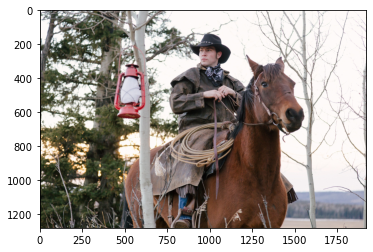

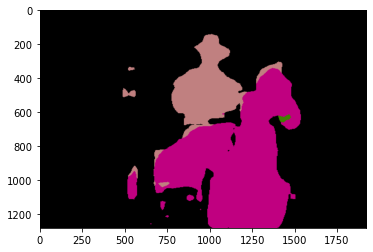

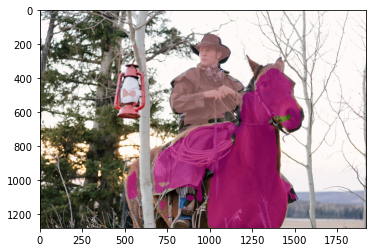

In [36]:
# 1. 원본 이미지 표시
image_file_path = "./data/trees-ge64ef1476_1920.jpg"
img = Image.open(image_file_path)   # [높이][폭][색RGB]
img_width, img_height = img.size
plt.imshow(img)
plt.show()

# 2. 전처리 클래스 작성
color_mean = (0.485, 0.456, 0.406)
color_std = (0.229, 0.224, 0.225)
transform = DataTransform(
    input_size=475, color_mean=color_mean, color_std=color_std)

# 3. 전처리
# 적당한 어노테이션 이미지를 준비하여 색상 팔레트 정보 추출
anno_file_path = val_anno_list[0]
anno_class_img = Image.open(anno_file_path)   # [높이][폭]
p_palette = anno_class_img.getpalette()
phase = "val"
img, anno_class_img = transform(phase, img, anno_class_img)

# 4. PSPNet으로 추론
net.eval()
x = img.unsqueeze(0)  # 미니 배치화：torch.Size([1, 3, 475, 475])
outputs = net(x)
y = outputs[0]  # AuxLoss 축은 무시, y의 크기는 torch.Size([1, 21, 475, 475])

# 5. PSPNet 출력으로 최대 클래스를 구하여 색상 팔레트 형식으로 화상 크기를 원래대로 되돌린다.
y = y[0].detach().numpy()  # y：torch.Size([1, 21, 475, 475])
y = np.argmax(y, axis=0)
anno_class_img = Image.fromarray(np.uint8(y), mode="P")
anno_class_img = anno_class_img.resize((img_width, img_height), Image.NEAREST)
anno_class_img.putpalette(p_palette)
plt.imshow(anno_class_img)
plt.show()

# 6. 이미지를 투과시켜 겹친다.
trans_img = Image.new('RGBA', anno_class_img.size, (0, 0, 0, 0))
anno_class_img = anno_class_img.convert('RGBA')  # 색상 팔레트 형식을 RGBA로 변환

for x in range(img_width):
    for y in range(img_height):
        # 추론 결과 이미지의 픽셀 데이터를 취득
        pixel = anno_class_img.getpixel((x, y))
        r, g, b, a = pixel

        # (0, 0, 0)의 배경이라면 그대로 투과시킨다.
        if pixel[0] == 0 and pixel[1] == 0 and pixel[2] == 0:
            continue
        else:
            # 그 외 색상은 준비된 이미지에 픽셀 기록
            trans_img.putpixel((x, y), (r, g, b, 150))
            # 투과율을 150으로 지정

img = Image.open(image_file_path)   # [높이][폭][색RGB]
result = Image.alpha_composite(img.convert('RGBA'), trans_img)
plt.imshow(result)
plt.show()
